# Building an image classifier using the Sequential API for Tensorflow

## Getting started with Fashion MNIST

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random

print(tf.__version__)

print(keras.__version__)

2.1.0
2.2.4-tf


In [2]:
#Building Image classifier using Sequential API

#Load the data from the keras datasets
fashion_mnist = keras.datasets.fashion_mnist

(X_train_full,y_train_full),(X_test,y_test) = fashion_mnist.load_data()

print(X_train_full.shape)
print(X_train_full.dtype)

print(X_test.shape)
print(X_test.dtype)

# # print("range(20) output: {}".format(range(20)))
# # print("np.arange(20) output: {}".format(np.arange(20)))

# a2 = np.arange(20)
# b = np.array(random.sample(range(20), 10))

# print(a2 ) 
# print(np.array_equal(a2 == b) 

# # print(type(np.array(b)))
# # print(type(a2))

# # print(a2)
# # print(b)
# # print(c)


(60000, 28, 28)
uint8
(10000, 28, 28)
uint8


In [3]:
# Create validation dataset

#Note, there is a way to specify the validation percent directly while compiling the model, but that takes only the last n% samples,
# and it seems that wont work if data is not shuffled

percent_samples = 20
total_samples = X_train_full.shape[0]

num_validation_samples = int(total_samples* percent_samples / 100)
print("Num validation samples to be used: {}".format(num_validation_samples))
print("Total number of samples : {}".format(total_samples))

#Get the shuffled indices 
a = np.arange(total_samples)
shuffled_idx = shuffle(a)

#Create the validation indices
idx_val = shuffled_idx[:num_validation_samples]

#Create the training indices
idx_train = shuffled_idx[num_validation_samples:]

#SLice the dataset
X_valid, X_train = X_train_full[idx_val] / 255.0, X_train_full[idx_train] / 255.0
y_valid, y_train = y_train_full[idx_val], y_train_full[idx_train]

# X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
# y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


Num validation samples to be used: 12000
Total number of samples : 60000


In [4]:
#Specify the class names:
class_names = ["tshirt", "trouser", "Pullover","Dress","Coat","Sandat","Shirt","Sneaker","Bag","Ankle boot"]

#Print an example to see if the code works
print(class_names[y_train[0]])

Coat


## Model creation and training

Showing images on grid of rows=2, and cols=5


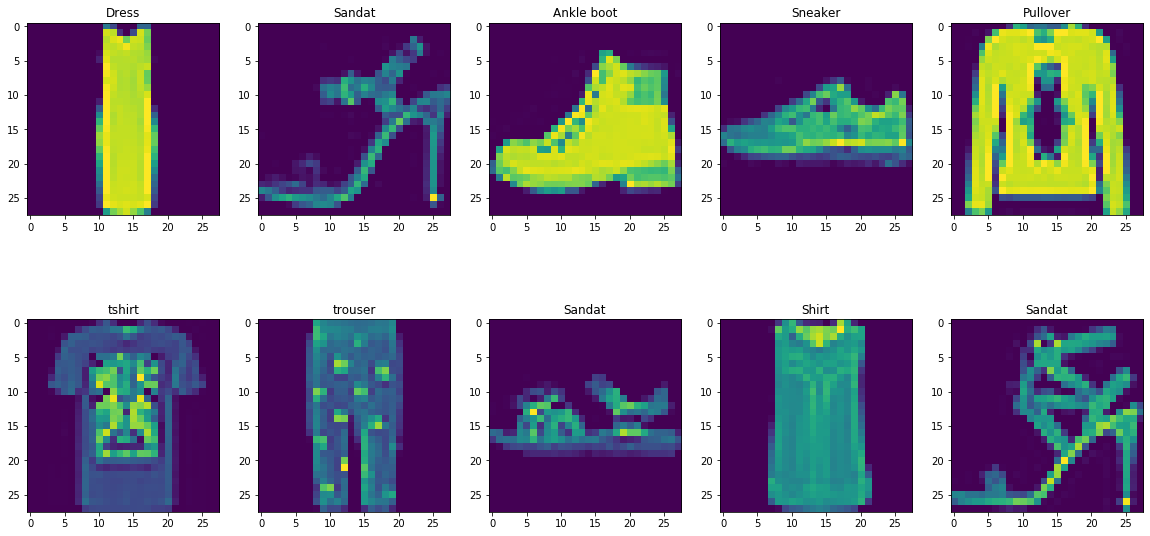

In [5]:
#Show some of the dataset
import random
num_show_samples = 10 
idx_show = random.sample(range(X_train.shape[0]),num_show_samples)
#print(idx_show)

# X_train[0]
# plt.subplot(2,2,1)
# plt.imshow(X_train[0])

rows = 2
cols = int(np.ceil(num_show_samples / rows))
print("Showing images on grid of rows={}, and cols={}".format(rows,cols))

plt.figure(figsize=(20,10))
for i in range(num_show_samples):
    ax =plt.subplot(rows,cols,i+1)
    ax.imshow(X_train[idx_show[i],:])
    plt.title("{}".format(class_names[y_train[idx_show[i]]]))
    

In [6]:
#Create the model using Sequential data API
# 1)
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[28,28]))
# model.add(keras.layers.Dense(300,activation="relu"))
# model.add(keras.layers.Dense(100,activation="relu"))
# model.add(keras.layers.Dense(10,activation="softmax"))

# 2)
# #OR create a model this way
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=[28,28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100,activation="relu"),
#     keras.layers.Dense(10,activation="softmax")    
# ], name="mnist_mlp")

# 3) 
#Note, you can also specify the input layer as
#keras.layers.InputLayer(input_shape=[28,28]) 
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=[28,28]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(10,activation="softmax")    
], name="mnist_mlp")


#Printing the model summary
model.summary()

# tf.keras.utils.plot_model(
#     model, to_file='../images/model.png', show_shapes=True, show_layer_names=True,
#     rankdir='TB', expand_nested=False, dpi=96
# )

#tf.keras.utils.plot_model(model, show_shapes=True)


Model: "mnist_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Print and access model layers
print("Model layers: {}".format(model.layers))

#Fetch by index
print("Layer idx 0: {}".format(model.layers[0]))
print("Layer idx 2: {}".format(model.layers[2]))

hidden1 = model.layers[1]
print(hidden1.name)

#Fetch by name
# temp_layer =  model.get_layer("dense_4")
# print(temp_layer.name)

#Access parameters of a given layer
weights,biases = hidden1.get_weights()
weights.shape


Model layers: [<tensorflow.python.keras.layers.core.Flatten object at 0x0000024D39746240>, <tensorflow.python.keras.layers.core.Dense object at 0x0000024D4BC99780>, <tensorflow.python.keras.layers.core.Dense object at 0x0000024D473CC710>, <tensorflow.python.keras.layers.core.Dense object at 0x0000024D4BCB6DD8>]
Layer idx 0: <tensorflow.python.keras.layers.core.Flatten object at 0x0000024D39746240>
Layer idx 2: <tensorflow.python.keras.layers.core.Dense object at 0x0000024D473CC710>
dense


(784, 300)

In [8]:
#Compile the model

#Using sparse_categorical_crossentropy because the target values are just target class indices 0-9,
#not one hot encoded vectors. For one hot encoded y_train, use categorical_crossentropy
#For binary classification, use binary_crossentropy, but also change the activation of output layer to be 
# sigmoid instead of the softmax activation

#keras.utils.to_categorical()
#print(keras.utils.to_categorical(y_train))

model.compile(loss="sparse_categorical_crossentropy",
             optimizer = "sgd",
             metrics = ["accuracy"])

## Callbacks for the model 

In [9]:
import os

model_folder_name = "mlp_basic"
model_name = model_folder_name + ".h5"

# Use save Modelcheckpoint callback so that I have intermediate versions of the trained model before the training has completed.
    #Byt default, this saves model at end of each epoch, but callbacks can be called at 
    # start/end of epoch, start/end of each batch, start/end of training 

#Use EarlyStopping to reduce resource usage.

#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.pardir,"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=10,
                                                     restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print("\n Epoch: {}, val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

#Instance of the custom callback
print_ratio_cb = PrintValTrainRatioCallback()


#Tensorboard callback
import os

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Saving tensorboard logs in: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# %load_ext tensorboard
# %tensorboard --logdir=run_logdir --port=6006


ModelCheckpoint Callback saves the model in: ..\models\mlp_basic\mlp_basic.h5
Saving tensorboard logs in: ..\models\mlp_basic\tensorboard\my_logs


In [10]:
#Launch tensorboard from the model

# %load_ext tensorboard
# %tensorboard --logdir=run_logdir --port=6006
#Train the model
history  = model.fit(X_train,y_train,epochs=100,
                     validation_data=(X_valid,y_valid),
                     callbacks=[checkpoint_cb, early_stopping_cb, print_ratio_cb, tensorboard_cb])



Train on 48000 samples, validate on 12000 samples
Epoch 1/100
47840/48000 [============================>.] - ETA: 0s - loss: 0.7442 - accuracy: 0.7552
 Epoch: 0, val/train loss ratio: 0.76
48000/48000 [==============================] - 7s 148us/sample - loss: 0.7438 - accuracy: 0.7555 - val_loss: 0.5690 - val_accuracy: 0.7918
Epoch 2/100
47552/48000 [============================>.] - ETA: 0s - loss: 0.4957 - accuracy: 0.8265
 Epoch: 1, val/train loss ratio: 0.99
48000/48000 [==============================] - 6s 134us/sample - loss: 0.4953 - accuracy: 0.8267 - val_loss: 0.4920 - val_accuracy: 0.8275
Epoch 3/100
47584/48000 [============================>.] - ETA: 0s - loss: 0.4488 - accuracy: 0.8428
 Epoch: 2, val/train loss ratio: 0.98
48000/48000 [==============================] - 6s 134us/sample - loss: 0.4486 - accuracy: 0.8426 - val_loss: 0.4412 - val_accuracy: 0.8465
Epoch 4/100
47488/48000 [============================>.] - ETA: 0s - loss: 0.4223 - accuracy: 0.8517
 Epoch: 3, val/

Epoch 30/100
47936/48000 [============================>.] - ETA: 0s - loss: 0.2312 - accuracy: 0.9171
 Epoch: 29, val/train loss ratio: 1.34
48000/48000 [==============================] - 6s 135us/sample - loss: 0.2311 - accuracy: 0.9171 - val_loss: 0.3094 - val_accuracy: 0.8892
Epoch 31/100
47968/48000 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.9181
 Epoch: 30, val/train loss ratio: 1.32
48000/48000 [==============================] - 7s 138us/sample - loss: 0.2289 - accuracy: 0.9181 - val_loss: 0.3019 - val_accuracy: 0.8926
Epoch 32/100
47840/48000 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9191
 Epoch: 31, val/train loss ratio: 1.37
48000/48000 [==============================] - 6s 134us/sample - loss: 0.2244 - accuracy: 0.9193 - val_loss: 0.3082 - val_accuracy: 0.8893
Epoch 33/100
47648/48000 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9206
 Epoch: 32, val/train loss ratio: 1.41
48000/48000 [======

(0, 1)

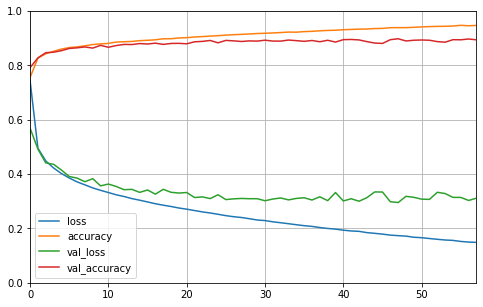

In [11]:
#Plot the history
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Set the vertical range to [0 -1]

# Note that the training and validation accuracy are still improving, 
# so we can probably increase the number of training epochs.  

## Evaluate Model

In [12]:
#Test
model.evaluate(X_test,y_test)

    

10000/10000 [==============================] - 1s 83us/sample - loss: 64.9153 - accuracy: 0.8547


[64.91525642930387, 0.8547]

Indices to be tested: [60, 32, 1, 96, 24, 3, 21, 29, 75, 9]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[7 3 2 0 1 1 5 4 3 7]
Class Names: ['tshirt', 'trouser', 'Pullover', 'Dress', 'Coat', 'Sandat', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Showing images on grid of rows=4, and cols=3
Actual Class: Sneaker, Pred class: Sneaker
Actual Class: Dress, Pred class: Dress
Actual Class: Pullover, Pred class: Pullover
Actual Class: tshirt, Pred class: tshirt
Actual Class: trouser, Pred class: trouser
Actual Class: trouser, Pred class: trouser
Actual Class: Sandat, Pred class: Sandat
Actual Class: Dress, Pred class: Coat
Actual Class: Dress, Pred class: Dress
Actual Class: Sneaker, Pred class: Sneaker


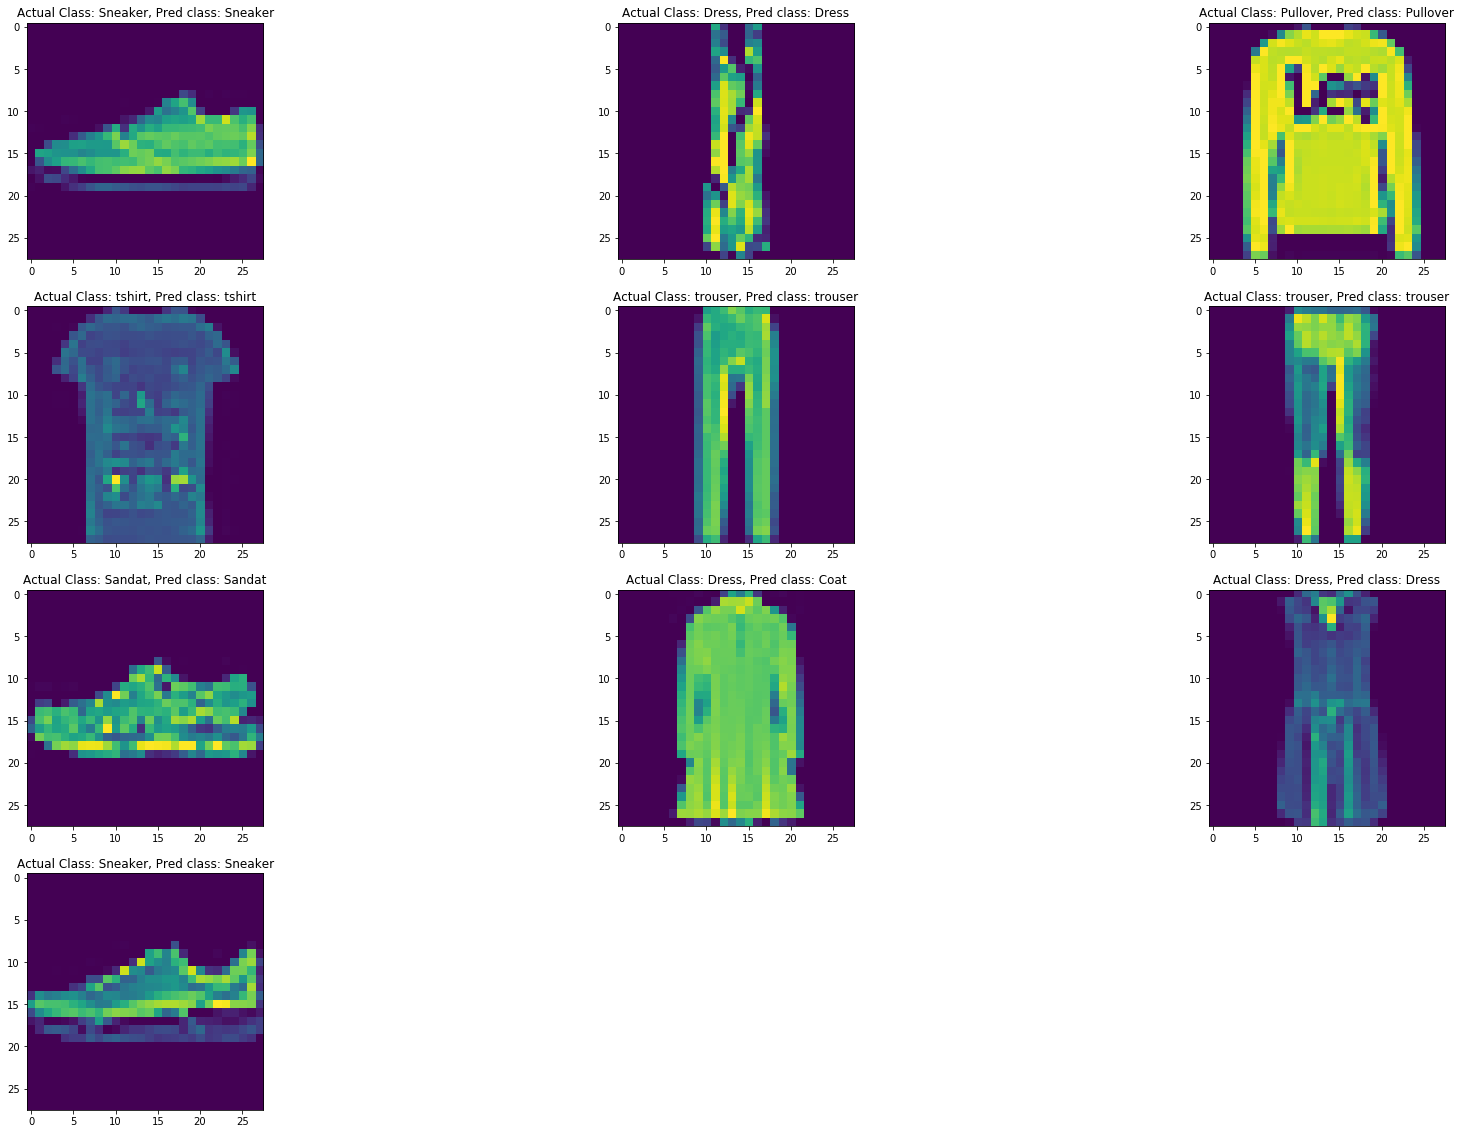

In [13]:
# Evaulate on new instances
#Get random set of indices
import random
num_show_samples = 10 

idx_vals = random.sample(range(100),num_show_samples)
#idx_vals = np.arange(X_test.shape[0])
print("Indices to be tested: {}".format(idx_vals))

X_new = X_test[idx_vals]
y_new = y_test[idx_vals]

#Predict probabilities
y_probab = model.predict(X_new)
#print(y_probab.round(2))
print(y_probab)
#y_pred_class = np.argmax(y_pred,1)

#Predict class
y_pred_class = model.predict_classes(X_new)
print(y_pred_class)
print("Class Names: {}".format(class_names))


rows = 4
cols = int(np.ceil(num_show_samples / rows))
print("Showing images on grid of rows={}, and cols={}".format(rows,cols))


plt.figure(figsize=(30,20))
for i in range(num_show_samples):
    print("Actual Class: {}, Pred class: {}".format(class_names[y_new[i]],class_names[y_pred_class[i]]))
    ax =plt.subplot(rows,cols,i+1)
#     ax.imshow(X_new[i,:],cmap='gray')
    ax.imshow(X_new[i,:])
    plt.title("Actual Class: {}, Pred class: {}".format(class_names[y_new[i]],class_names[y_pred_class[i]]))


In [14]:
#Save the model
# Might not be needed if the callbacks are used to save models

# # model_folder_name = "mlp_basic"
# # full_filepath_model_file = "../models/" + model_folder_name + ".h5"
# print(" Saving model to: {}".format(save_model_filepath))
# model.save(save_model_filepath)

# Loading a saved model
#model2 = keras.models.load_model("../models/mlp_basic.h5")


## Tensorboard